1. Derive eigenvectors and their eigenvalues from image and spectral data.
2. Convert a digital camera into a spectral imager using principal components analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy.fft as fft
from tqdm import tqdm
from skimage.measure import compare_mse as mse


### Loading Face database

In [5]:
path = "G:\\My Drive\\MS Physics\\2.2\\Physics-301\\03 PCA for Compression\\Faces\\"

def objects(path = path):
    object  = os.listdir(path)
    #names.append()
    return object

name = objects()
name.sort()

In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in name:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return images

In [7]:
faces = load_images_from_folder(path)

 ## Dataset Processing

### Raveling into an `N x 2500` array

In [9]:
DATA = np.zeros(shape=(len(faces), 2500)) 
for i in range(len(faces)):
    DATA[i,:] = np.ravel(faces[i])

### Covariance Matrix

In [10]:
DATA_cov = np.cov(DATA)

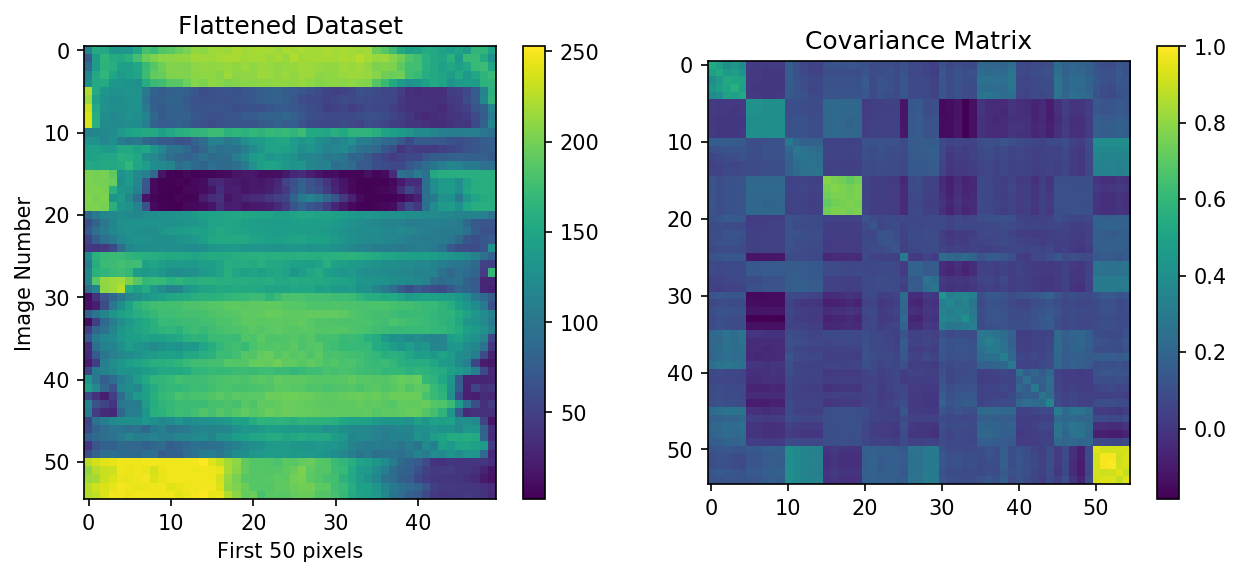

In [11]:
plt.figure(figsize=(10,4), dpi = 150)
plt.subplot(121)
plt.imshow(DATA[:,0:50])
plt.title("Flattened Dataset")
plt.xlabel("First 50 pixels")
plt.ylabel("Image Number")
plt.colorbar()

plt.subplot(122)
plt.imshow(DATA_cov/DATA_cov.max())
plt.title("Covariance Matrix")
plt.colorbar()

# Principal Components Analysis

In [11]:
from sklearn.decomposition import PCA

pca = PCA(len(DATA))
pca.fit(DATA)
mean = pca.mean_
eigenvector = pca.components_
eigenvalues = pca.explained_variance_
explained = pca.explained_variance_ratio_

## Percent (%) Explained

Text(0.5,0,'number of components')

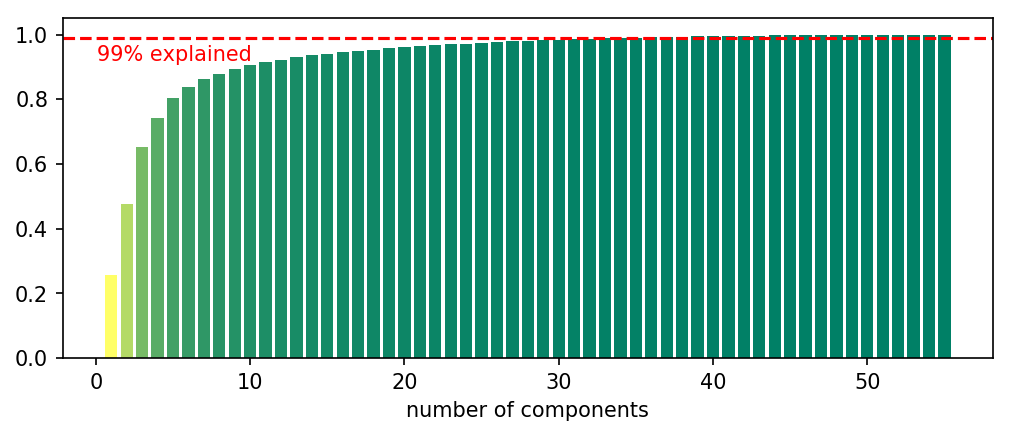

In [14]:
plt.figure(figsize=(8,3), dpi = 150)

plt.bar(range(1, 56), np.cumsum(explained), 
            color = plt.cm.summer_r((np.cumsum(explained)-explained[0])/(1-explained[0])))

plt.axhline(0.99, color = 'r', ls = "--")
plt.text(0.1, 0.92, "99% explained", color = "r")
plt.xlabel("number of components")

## Eigenvectors

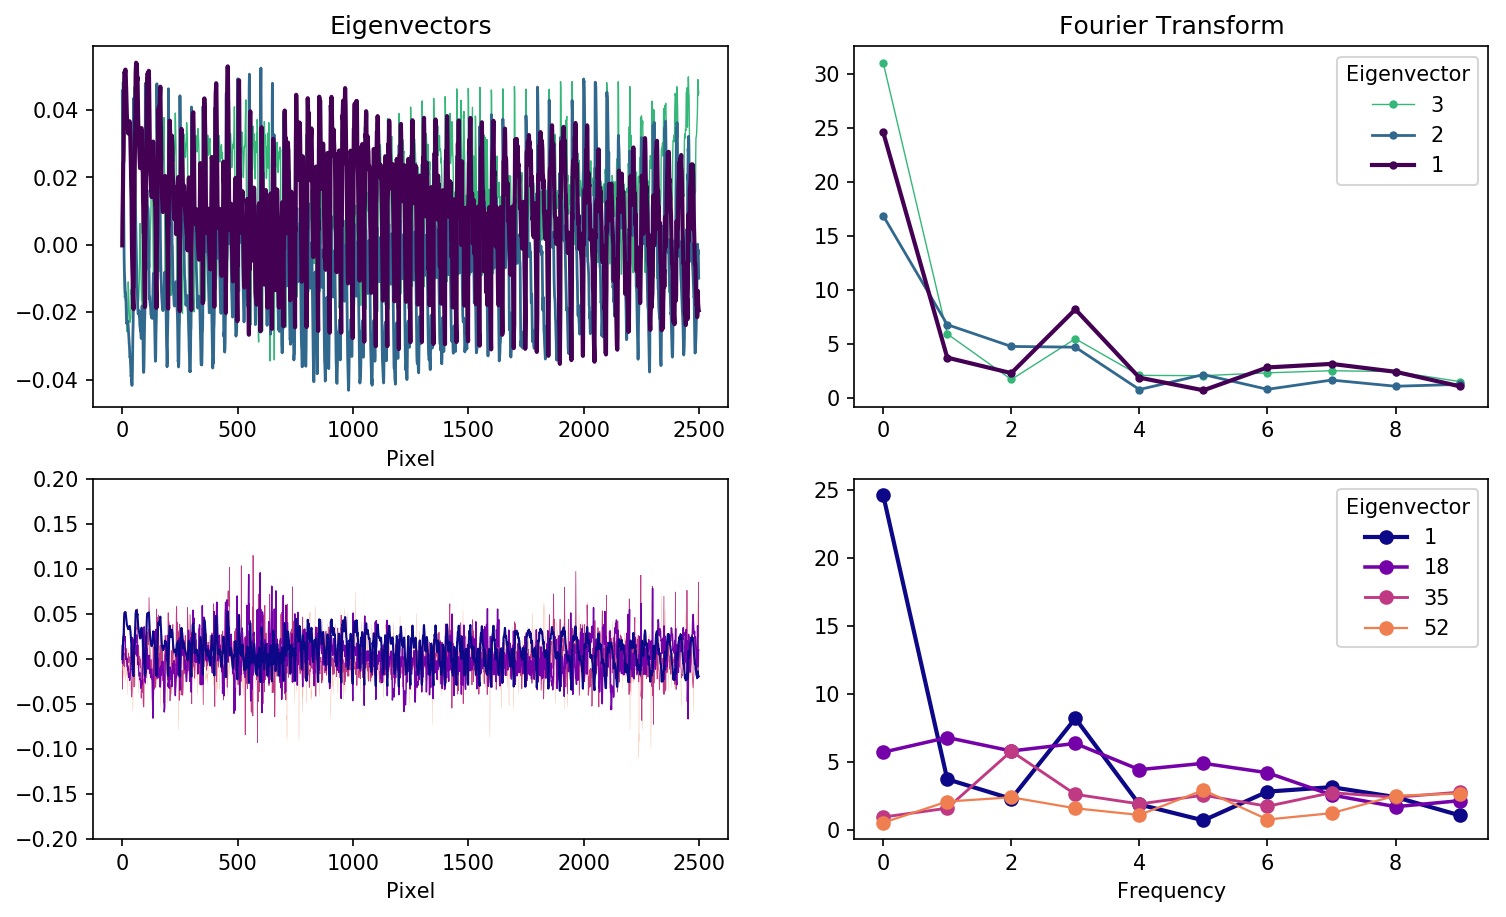

In [17]:
components = 3

plt.figure(figsize=(12,7), dpi = 150)

plt.subplot(221)

for i in np.flip(range(components)):
    plt.plot(eigenvector[i,:], label = str(i+1),
             color = plt.cm.viridis(i/components), lw = 2*(components - i)/components)
plt.title("Eigenvectors")
plt.xlabel("Pixel")

# plt.ylim(-0.2,0.2)

plt.subplot(222)
for i in np.flip(range(components)):
    FT = abs(fft.fft(eigenvector[i,:]))
    plt.plot(FT[:10], ".-", label = str(i+1),
             color = plt.cm.viridis(i/components), lw = 2*(components - i)/components)
plt.title("Fourier Transform")
legend = plt.legend()
legend.set_title("Eigenvector")

plt.subplot(223)

for i in np.flip(np.arange(0,55,17)):
        plt.plot(eigenvector[i,:], label = str(i+1),
                 color = plt.cm.plasma(i/75), lw = 1*(55 - i)/55)
plt.ylim(-0.2,0.2)
plt.xlabel("Pixel")

plt.subplot(224)

for i in np.arange(0,55,17):
    FT = abs(fft.fft(eigenvector[i,:]))
    plt.plot(FT[:10], "o-", label = str(i+1),
             color = plt.cm.plasma(i/75), lw = 2*(55 - i*0.5)/55)
    plt.xlabel("Frequency")
legend = plt.legend()
legend.set_title("Eigenvector")

# plt.show()


# Reconstruction Accuracies

In [34]:
RMSE = np.zeros(shape=[55,54])
SAM = np.zeros(shape=[55,54])

face_rec = []

for xx in tqdm(range(55)):
    sam = []
    rmse = []
    
    rec_ = []
    for n in range(0,54):
        test = DATA[xx,:]
        test_less_mu = test - mean
        coeffs = np.dot(eigenvector, test_less_mu)
        PC = coeffs*eigenvector.T

        # pcs = [1,5,10]

        for j in range(1, n+2):
            PC[:,0] += PC[:,j]
            reconstruction = PC[:,0] + mean

        x,y = test, reconstruction
        actual = x.reshape((50,50))
        rec = y.reshape((50,50))
        rec_.append(rec)
        rmse.append(np.sqrt(mse(actual, rec))/255)
        sam.append(np.arccos(sum(x*y)/(np.sqrt(sum(x**2))*(np.sqrt(sum(y**2))))))
        
    RMSE[xx,:] = rmse
    SAM[xx,:] = sam
    face_rec.append(rec_)

100%|██████████████████████████████████████████| 55/55 [00:04<00:00, 11.16it/s]


## RMSE & SAM Error Maps

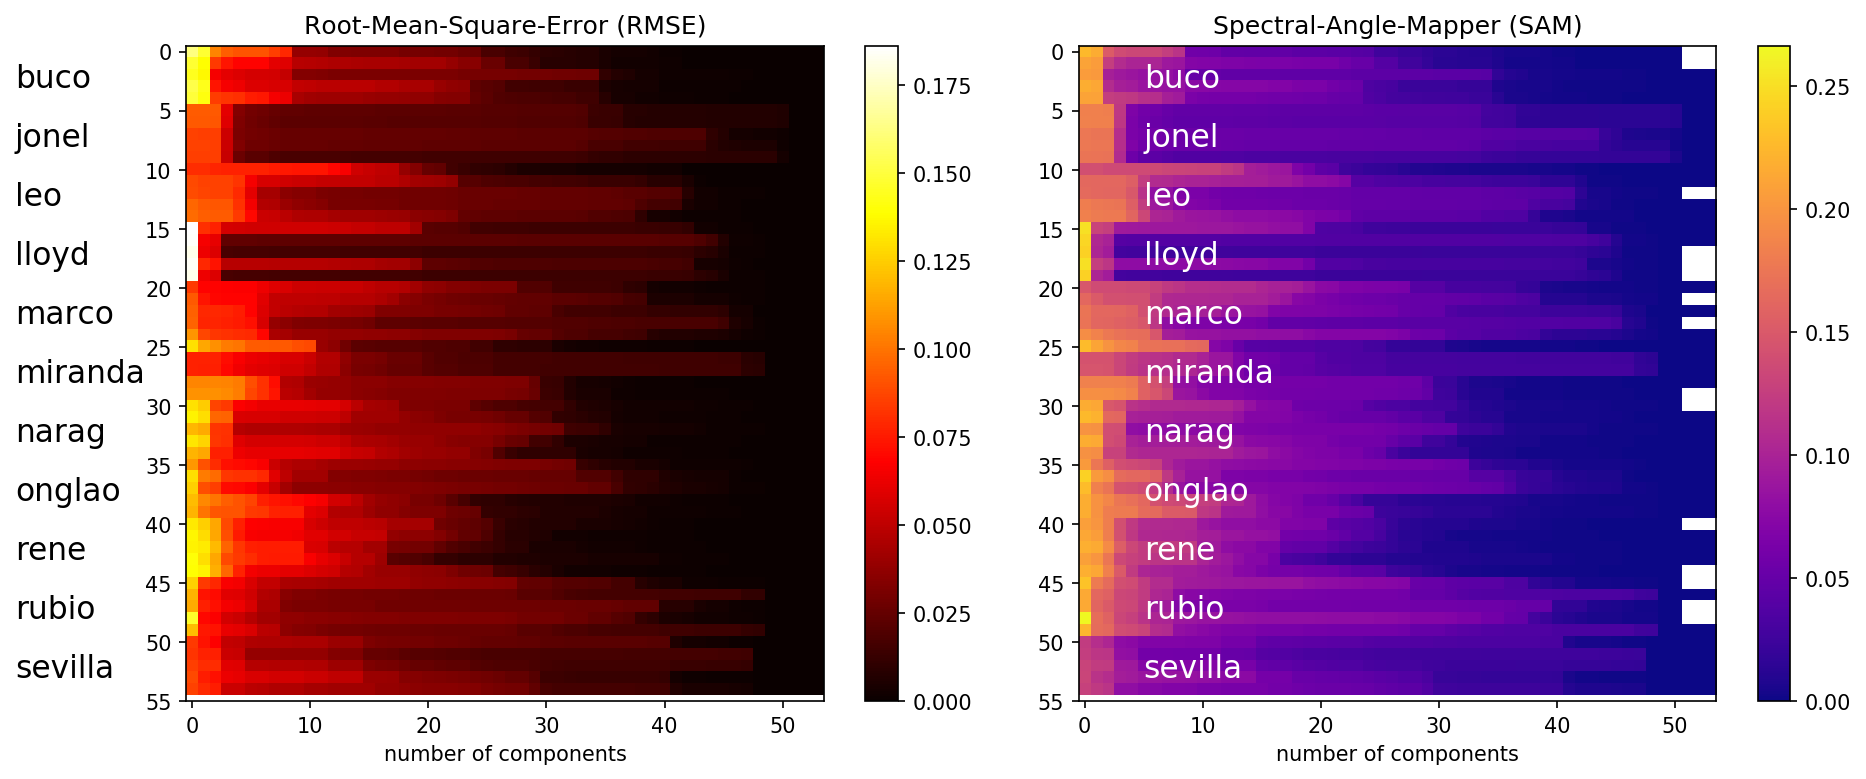

In [99]:
plt.figure(figsize=(12,5), dpi = 150)
plt.subplot(121)
plt.title("Root-Mean-Square-Error (RMSE)")
plt.imshow(np.array(RMSE), cmap = 'hot')
plt.colorbar()
for i in range(11):
    plt.text(-15, i*5 + 3, str(name[5*i][:-6]), color = 'k',fontsize = 15)
plt.xlabel("number of components")
plt.yticks(np.arange(0,56,5))


plt.subplot(122)
plt.title("Spectral-Angle-Mapper (SAM)")
plt.imshow(np.array(SAM), cmap = "plasma")
plt.colorbar()
for i in range(11):
    plt.text(5, i*5 + 3, str(name[5*i][:-6]), color = 'w', fontsize = 15)
plt.xlabel("number of components")
plt.yticks(np.arange(0,56,5))

plt.tight_layout()

## Average Accuracy per Person

In [100]:
RMSE_ave = np.zeros(shape=[11,54])
SAM_ave = np.zeros(shape=[11,54])

for i in range(0,11):
    RMSE_ave[i,:] = (RMSE[0+5*i:5+5*i,:].mean(axis=0))
    SAM_ave[i,:] = (SAM[0+5*i:5+5*i,:].mean(axis=0))

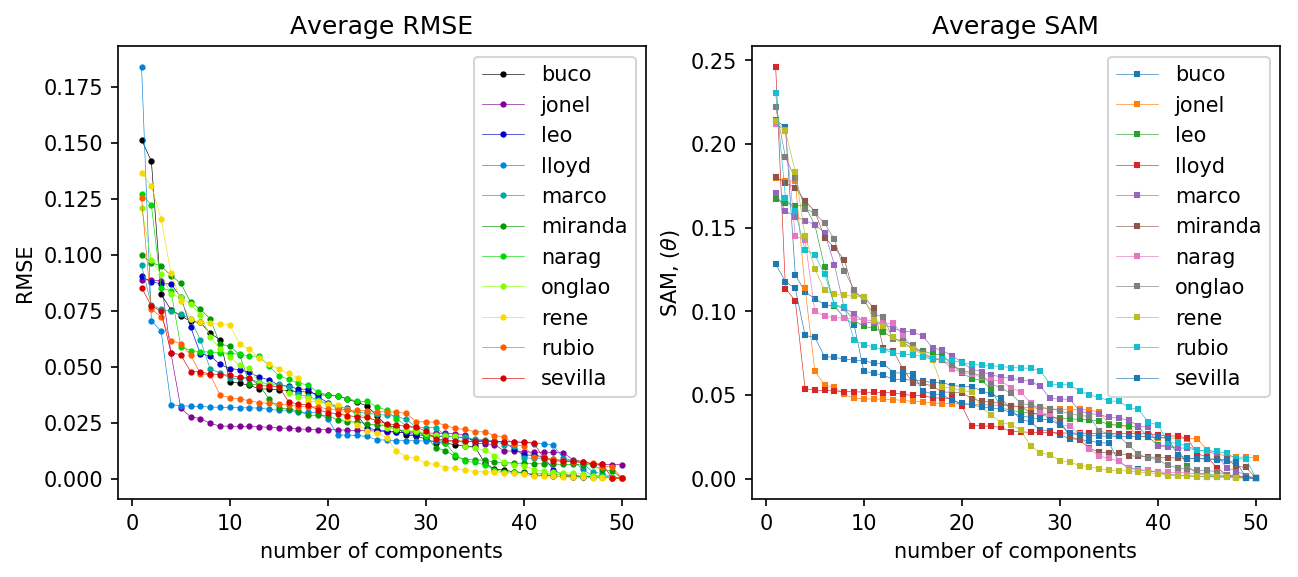

In [101]:
plt.figure(figsize=(10,4), dpi = 150)

n = 50

plt.subplot(121)
plt.title("Average RMSE")
for i in range(11):    
    plt.plot(range(1,n+1), RMSE_ave[i].T[:n], marker = 'o', ms = 2, lw = 0.3, color = plt.cm.nipy_spectral(i/11),
            label = str(name[5*i][:-6]))
plt.ylabel("RMSE")
plt.xlabel("number of components")
plt.legend()

plt.subplot(122)
plt.title("Average SAM")
for i in range(11):
    plt.plot(range(1,n+1), SAM_ave[i].T[:n], ms = 2, lw = 0.3,# color = plt.cm.plasma(i/11),
             label = str(name[5*i][:-6]), marker = 's')

plt.ylabel("SAM, $(\\theta$)")
plt.xlabel("number of components")
plt.legend()
plt.show()


## Ensemble Reconstruction Accuracy

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5,0.98,'Reconstruction Accuracies')

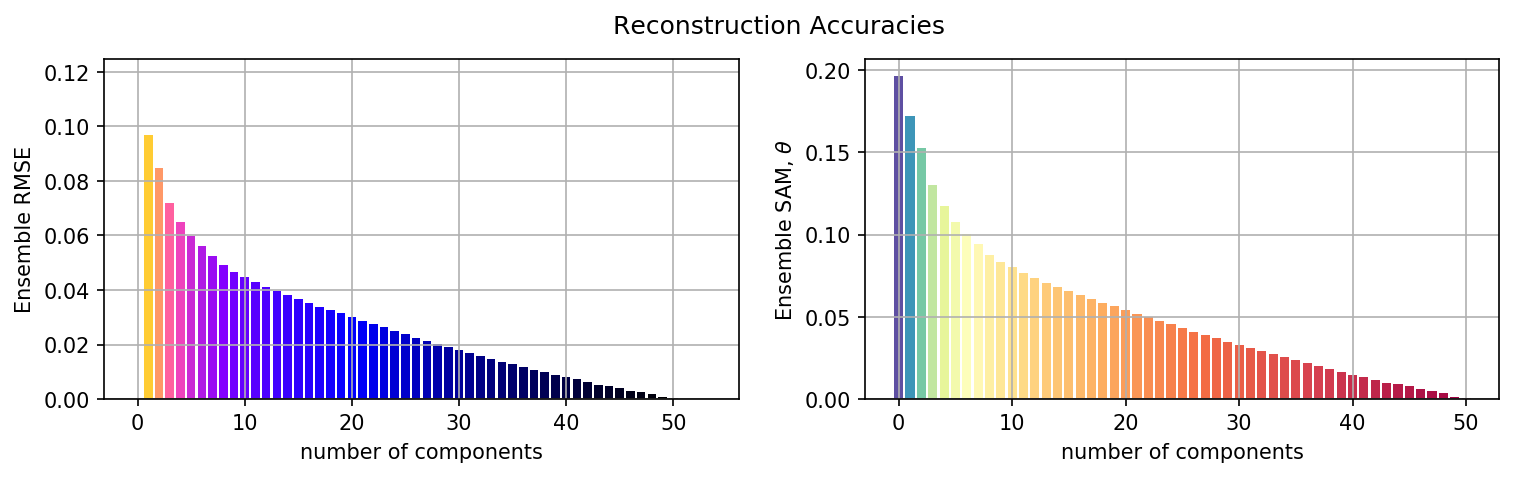

In [103]:
plt.figure(figsize=(12,3), dpi = 150)
plt.grid()

plt.subplot(121)
plt.grid()

mean_RMSE = np.mean(RMSE, axis = 0)
plt.bar(range(54),mean_RMSE, 
        color = plt.cm.gnuplot2(mean_RMSE/mean_RMSE[0]))
plt.ylabel("Ensemble RMSE")
plt.xlabel("number of components")

plt.subplot(122)
plt.grid()
mean_SAM = np.mean(SAM, axis = 0)
plt.bar(range(54), mean_SAM,
        color = plt.cm.Spectral(mean_SAM/mean_SAM[0]))
plt.ylabel("Ensemble SAM, $\\theta$")
plt.xlabel("number of components")
plt.suptitle("Reconstruction Accuracies")

# Rendering the Faces

In [197]:
def render_face(i):
    test_comp = [1,2,3,10,30,50]

    plt.figure(figsize = (8,2), dpi = 150)

    plt.subplot(1,7,1)
    plt.imshow(faces[i], cmap = 'gray')
    plt.axis('off')
    plt.title(str(name[i][:-6]), fontsize = 8)

    for n in test_comp:
        plt.subplot(1,7,test_comp.index(n)+2)
        plt.imshow(face_rec[i][n], cmap = 'gray')
        plt.xlabel("RMSE = " + str(np.round(RMSE[i,n], 4)), fontsize = 5)
        plt.title("N = " + str(n), fontsize = 6)
        plt.text(25, 47, "$\\theta$ = " + str(np.round(SAM[i,n], 3)), fontsize = 5, color = 'r')
        plt.xticks([])
        plt.yticks([])

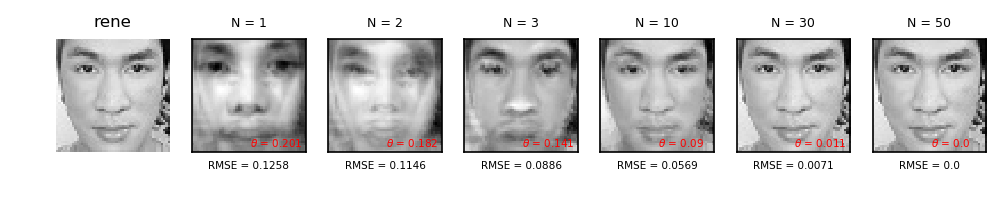

In [198]:
render_face(40)

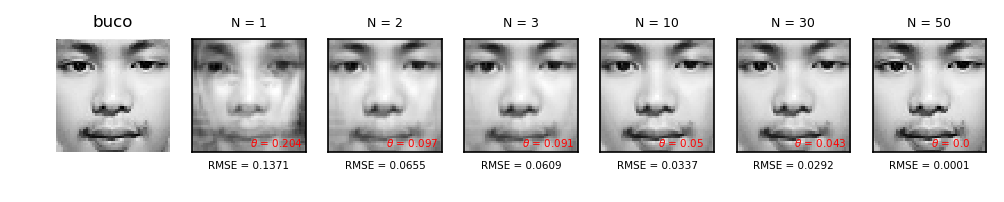

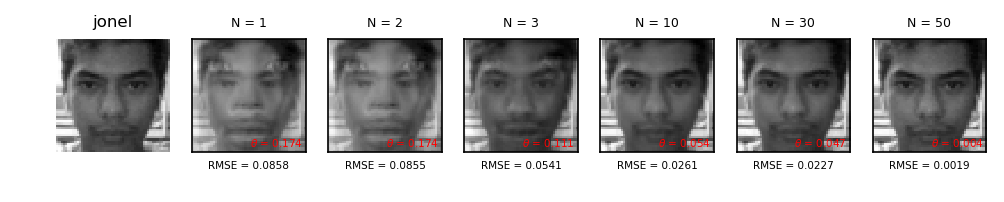

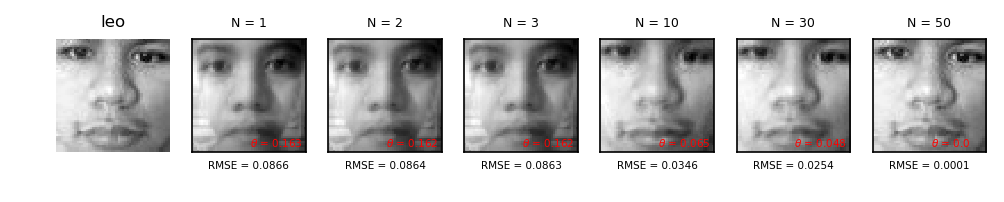

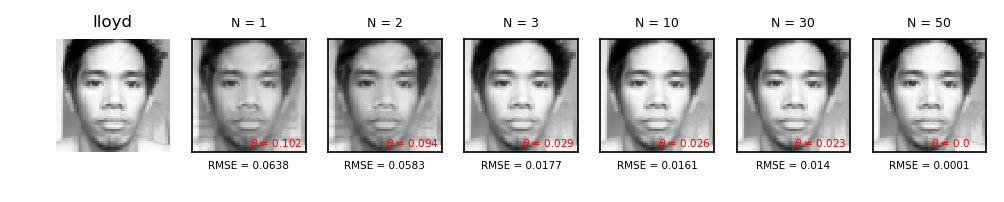

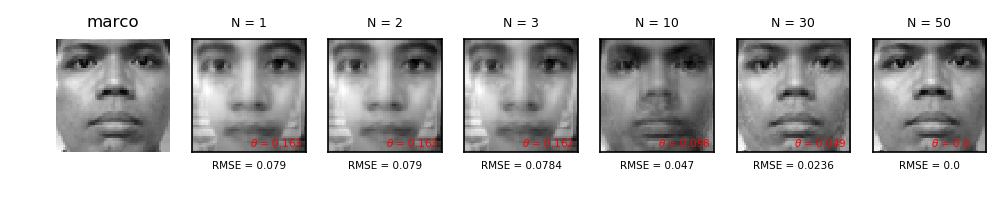

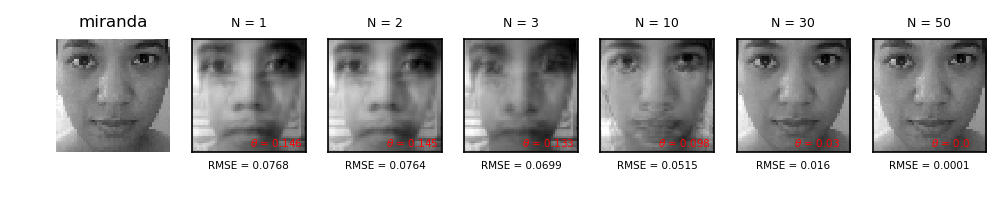

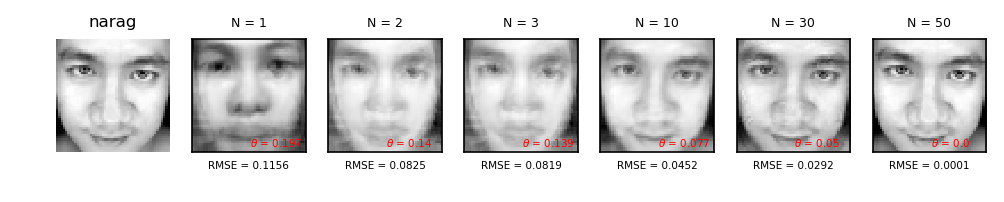

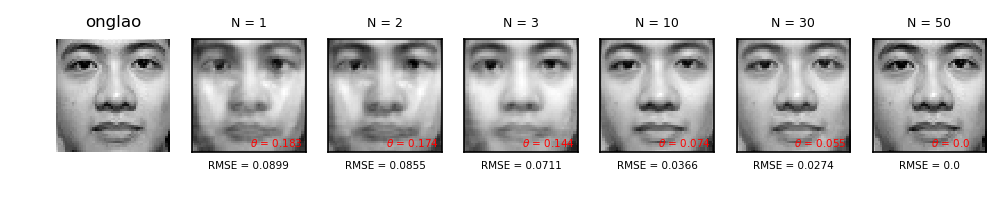

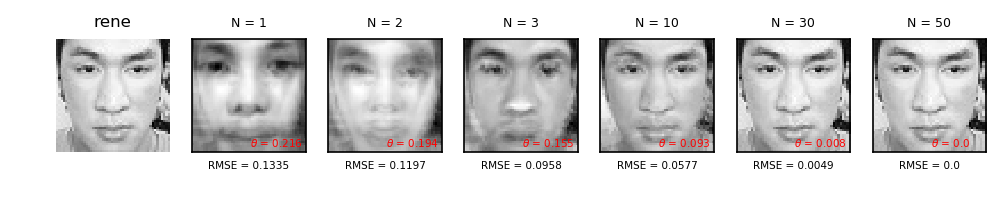

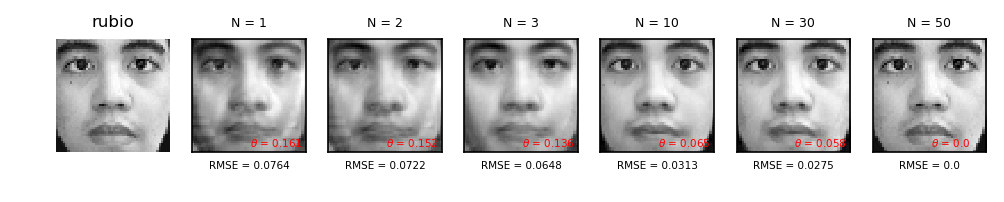

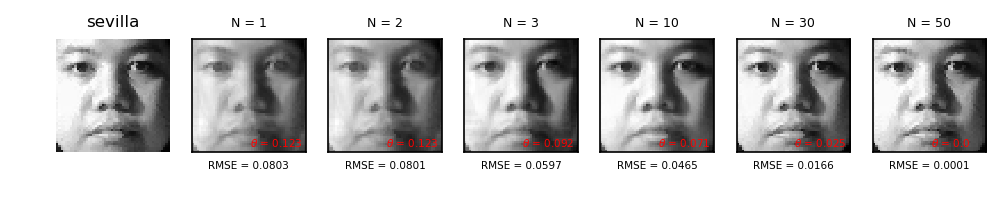

In [199]:
for i in range(11):
    render_face(i*5+2)